In [59]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


#Study1
-----------------------------------------------------------------
데이터를 읽어오고, 형태를 확인하겠습니다.<br>
(아이펠 컨테이너 형성 오류로 인해 Google colab에서 코딩을 진행했습니다.<br> 가상환경에 data를 가져와 학습을 진행하여 디렉토리 path에 차이가 있습니다.)

In [37]:
data_dir = join('../content/sample_data')
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

../content/sample_data/train.csv
../content/sample_data/test.csv


In [38]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6555, 20)


In [39]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [40]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21590


In [41]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 데이터 전처리 
### 1. 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<Axes: >

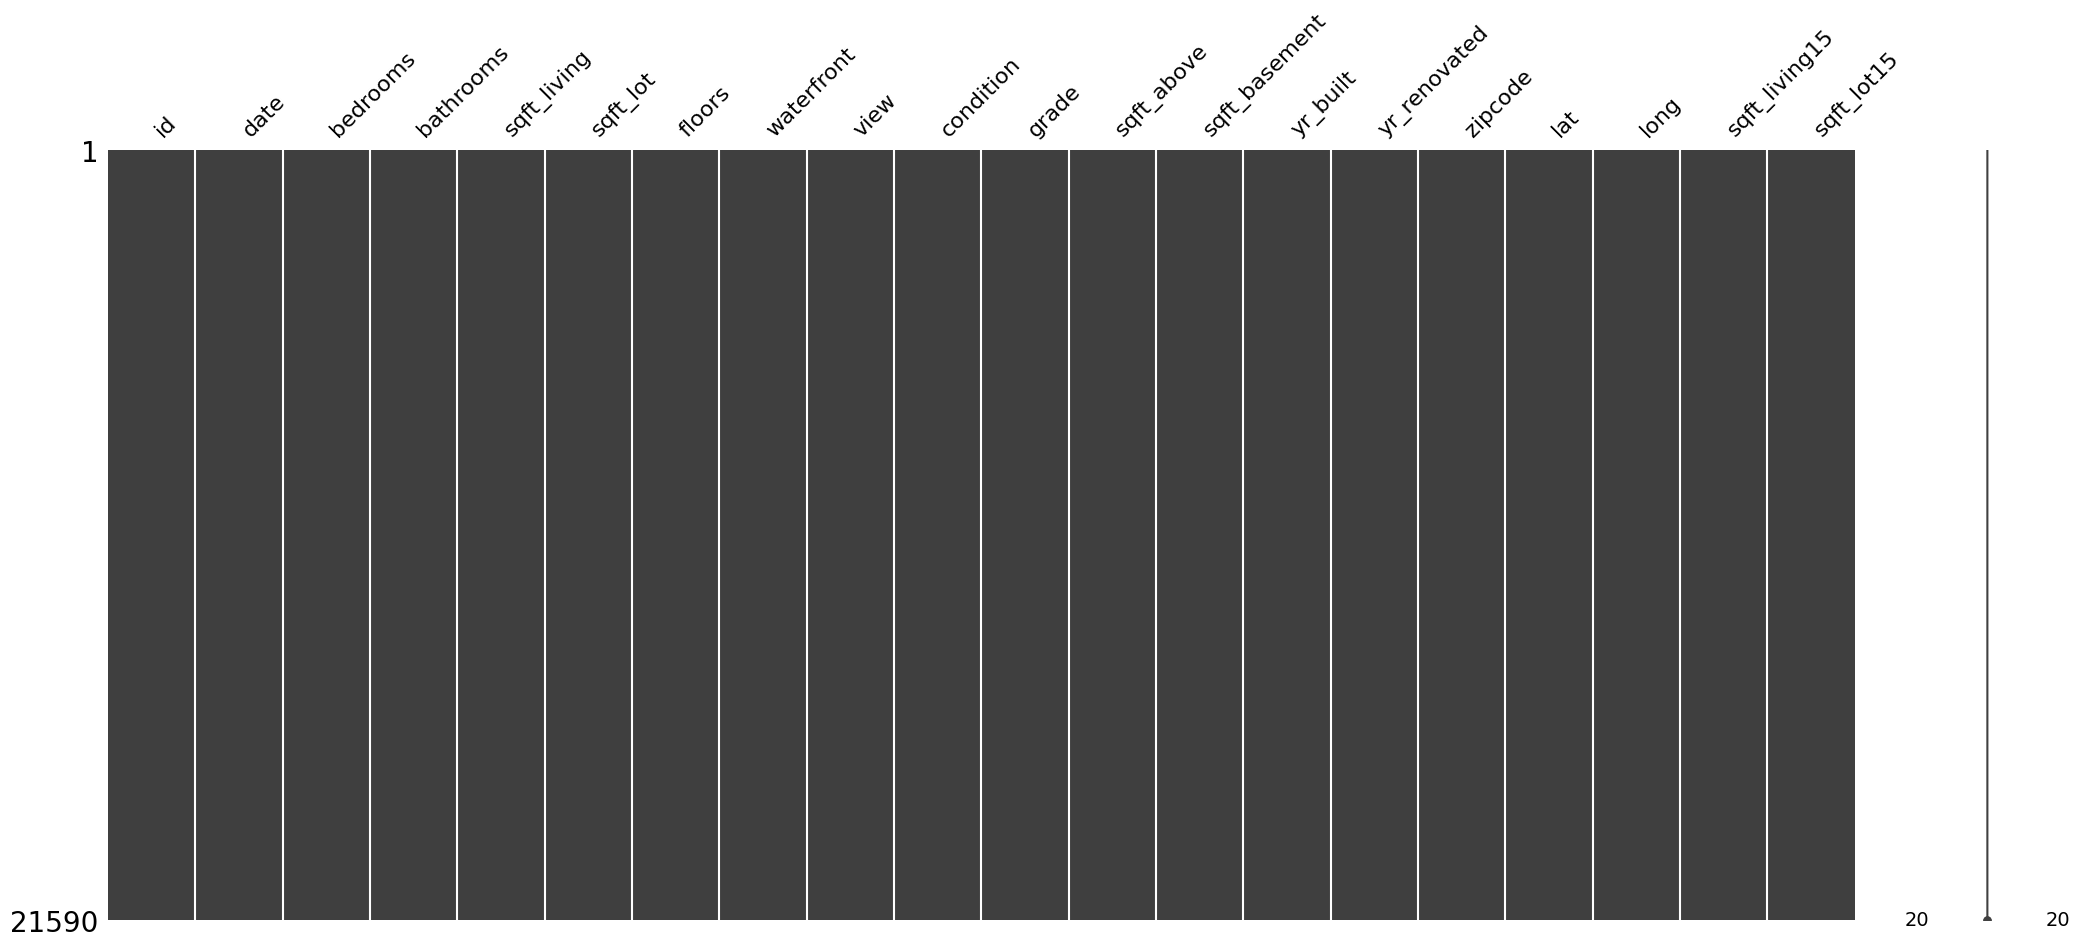

In [42]:
msno.matrix(data)

In [43]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2. id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 데이터에서 제거합니다.<br>
추가적으로 submission 데이터에 사용하기위해 id 변수를 sub_id에 저장하였습니다.<br><br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [44]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [45]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 3. 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 로그 스케일로 바꿔서 데이터를 정규분포에 가깝게 수정하였습니다.

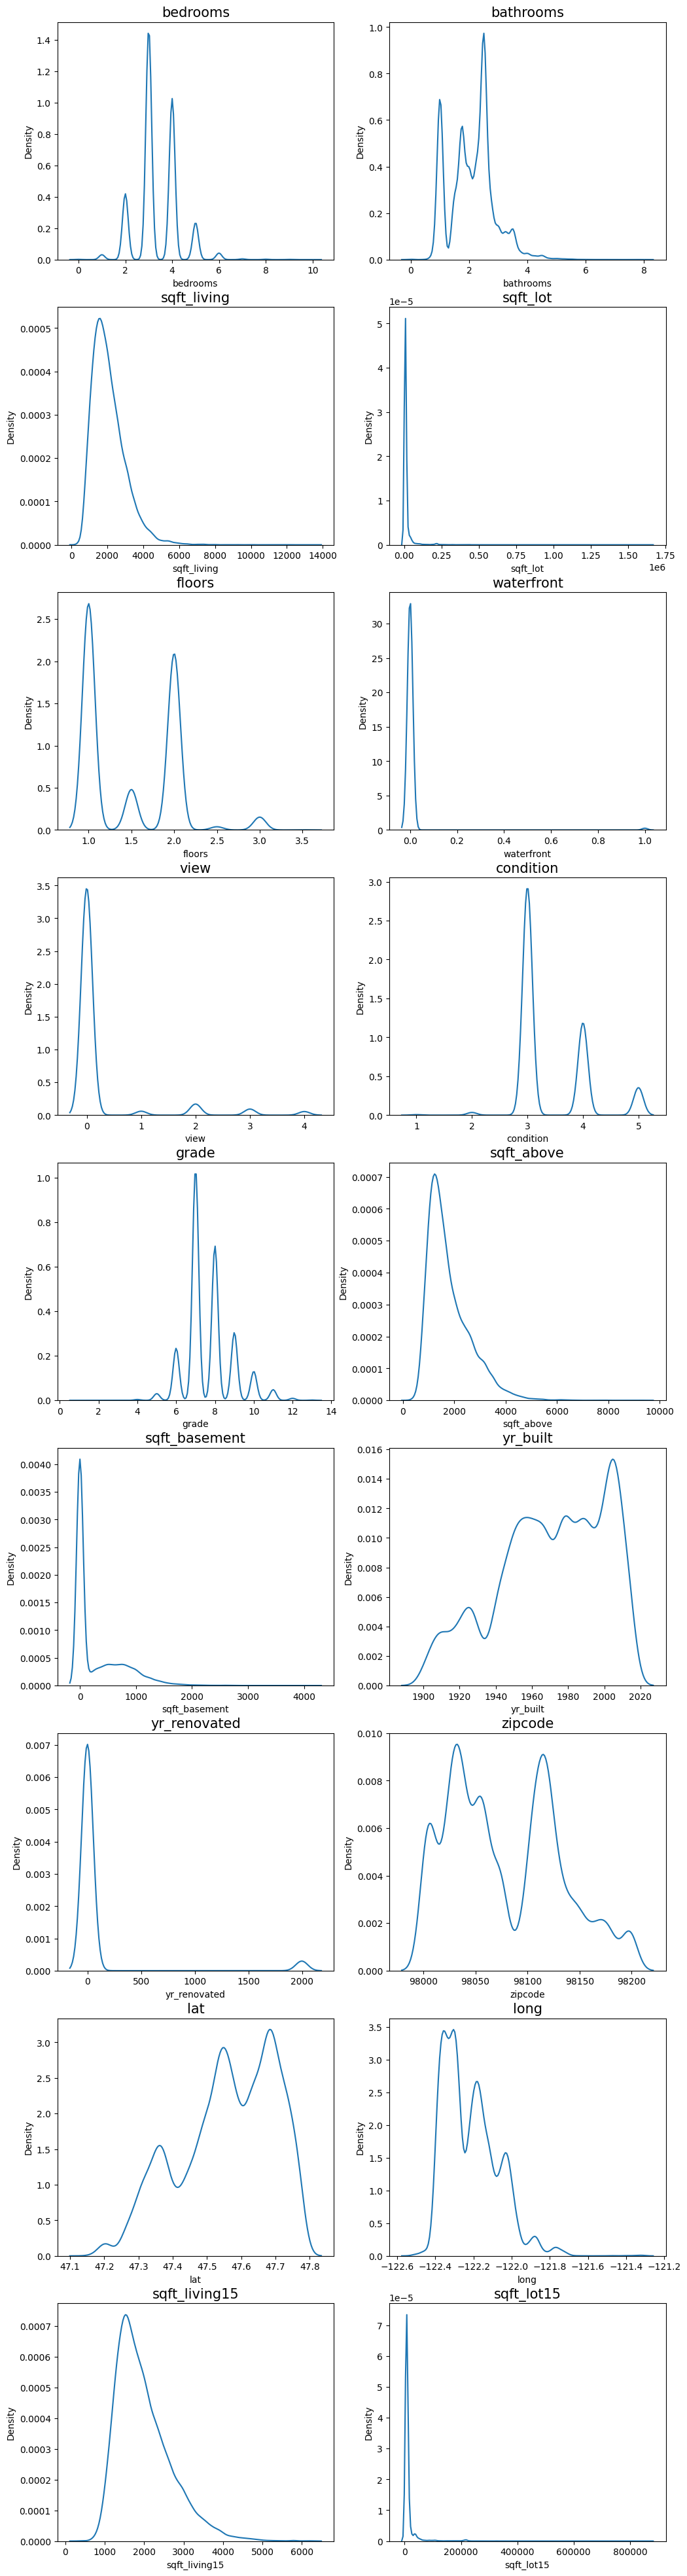

In [46]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))  

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [47]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

len(skew_columns)

얍💢


7

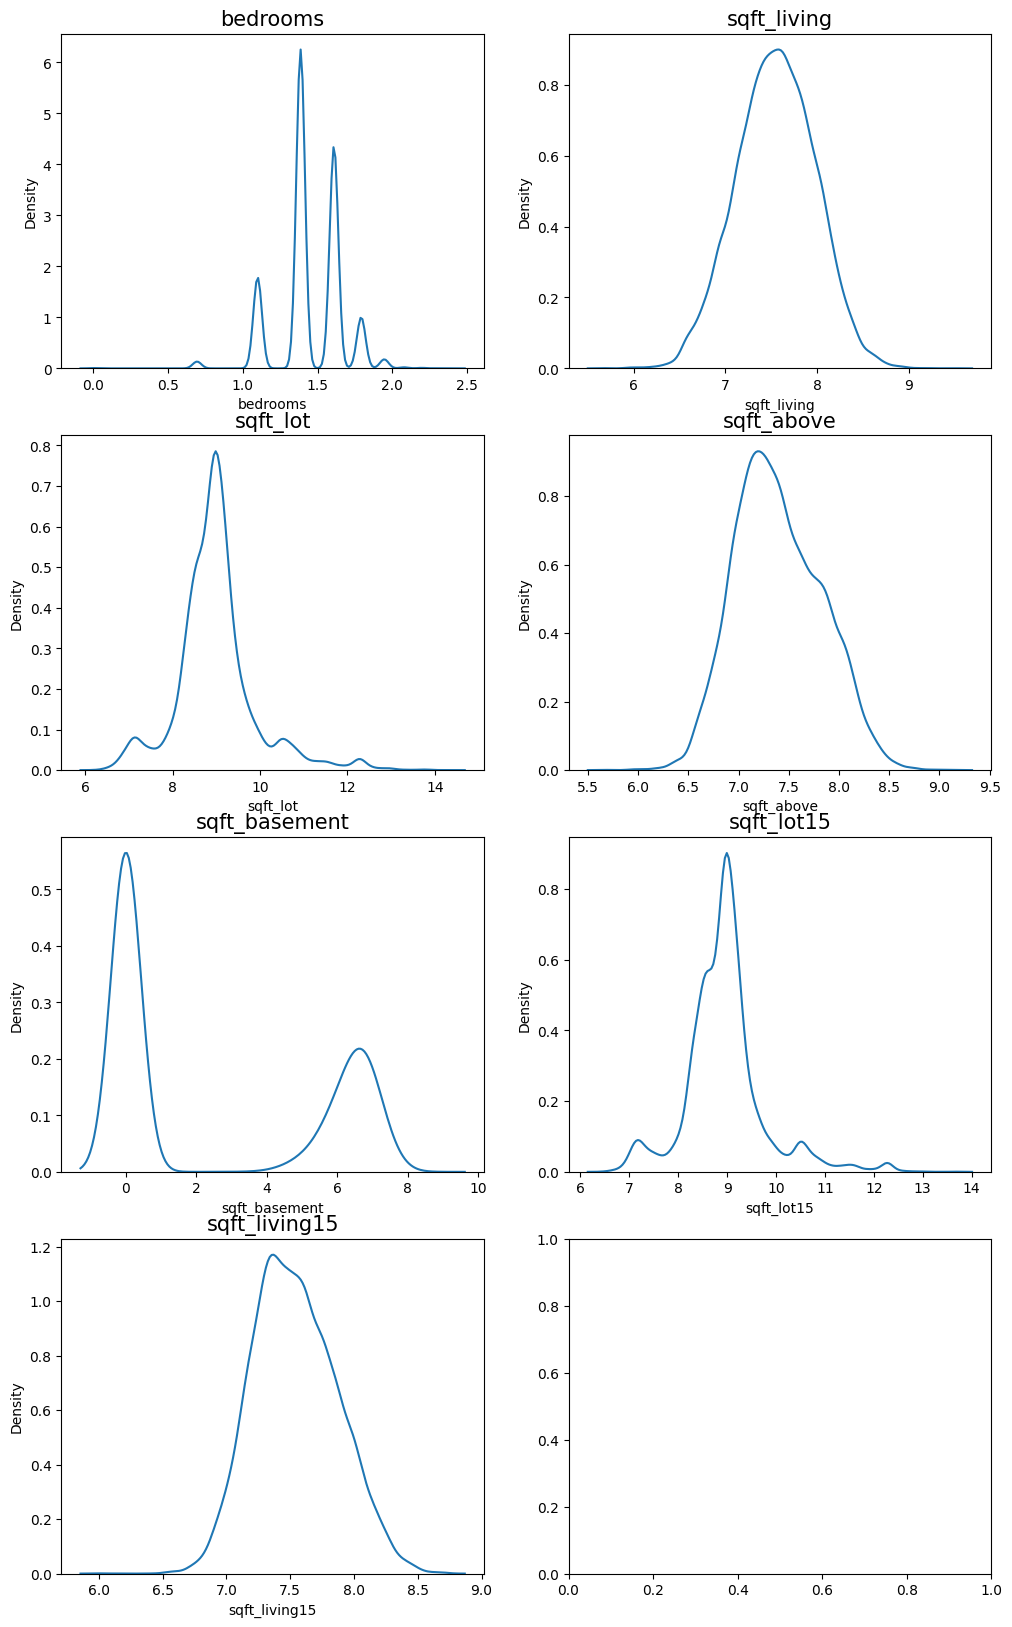

In [48]:
fig, ax = plt.subplots(4, 2, figsize=(12, 20)) 

count = 0
columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 7 :
            break

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [49]:
#train_len 값을 기준으로 train data, test data를 나눈다.
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6555, 19)


## 모델학습
### 1. Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [80]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)
rdforest = RandomForestRegressor(random_state=2019)


models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]

### 2. Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [81]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [82]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819
Model: RandomForest, CV score:0.8696


## Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [83]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [84]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6555


array([1349470.30932082,  312603.54416721,  774719.43905978, ...,
       1668005.19185047,  417248.83893086,  339337.22264456])

In [85]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15208,1.349470e+06
1,15209,3.126035e+05
2,15210,7.747194e+05
3,15211,2.077335e+05
4,15212,4.285177e+05


In [56]:
my_submission_path = join(data_dir, 'submission.csv')

result.to_csv(my_submission_path,index = False)

print(my_submission_path)

../content/sample_data/submission.csv



#Study2
-----------------------------------------------------------------
## 여러 모델에 따른 Evaluation을 구하기 위한 함수 구현 및 그리드 탐색을 통한 하이퍼 파라미터 최적화
###1. 데이터 전처리

In [107]:
#데이터 가져오기
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

#date 자료형 변환
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#price y에 저장후 훈련데이터에서 제거
y = train['price']
del train['price']

#id 값 제거
del train['id']
sub_i = test['id']
del test['id']

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

#한쪽에 쏠려있는 값을 정규분포에 가깝기 만들기 위해 log값 변환
for c in skew_columns:
    train[c] = np.log1p(train[c].values)
for c in skew_columns:
    test[c] = np.log1p(test[c].values)
y = np.log1p(y)

print(train.shape)
print(test.shape)
print(y.shape)

(15035, 19)
(6555, 19)
(15035,)


###2. 모델학습

In [108]:
# 이번 경연대회의 evaluation인 RMSE 구현

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 모델에 따른 RMSE을 반환하는 함수 구현
models = [gboost, xgboost, lightgbm, rdforest]

def get_scores(models, train, y):
    
    df = {}
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=123)

    for model in models:
       model_name = model.__class__.__name__
       model.fit(X_train,y_train)
       prediction = model.predict(X_test)
       df[model_name] = rmse(y_test, prediction)
       score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,165417.607778
RandomForestRegressor,152393.041134
LGBMRegressor,147844.184555
XGBRegressor,146816.518339


###3.그리드 탐색을 통한 하이퍼 파라미터 최적화

In [109]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [110]:
model = lgb.LGBMRegressor(random_state=2019)

In [111]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

my_GridSearch(model, train, y, param_grid=param_grid, verbose=2, n_jobs=5)




Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164391
2,10,50,-0.029174,0.170804
1,1,100,-0.055024,0.234571
0,1,50,-0.073398,0.270920


In [112]:
model = lgb.LGBMRegressor(max_depth=10, n_estimators=100, random_state=2019)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)

result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head

<bound method NDFrame.head of          id         price
0     15208  1.349470e+06
1     15209  3.126035e+05
2     15210  7.747194e+05
3     15211  2.077335e+05
4     15212  4.285177e+05
...     ...           ...
6550  21758  4.268897e+05
6551  21759  5.175074e+05
6552  21760  1.668005e+06
6553  21761  4.172488e+05
6554  21762  3.393372e+05

[6555 rows x 2 columns]>

###4.Submission

In [113]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = result['price']
submission.head()

,id,price
0,15035,1.349470e+06
1,15036,3.126035e+05
2,15037,7.747194e+05
3,15038,2.077335e+05
4,15039,4.285177e+05


In [114]:
submission.to_csv(my_submission_path, index=False)
print(my_submission_path)

../content/sample_data/submission.csv


-----------------------------------------------------------------
#Study3
###다양한 모델의 하이퍼 파라미터를 그리드 탐색을 통해 최적화하고, 블렌딩 방법을 사용하여 RMSE 최적화